In [40]:
par_log_transform = True

In [41]:
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib import rc
import matplotlib.colors as colors
from utils.my_plotting_lib import plot_barcodes, plot_conf_ellipse, label_axes
rc('text', usetex=True)

In [42]:
labels = {
        'exact': f'smFISH exact',
        'binomial': f'smFISH missing spots',
        'flowcyt': f'Flow cytometry',
        'poisson': f'Additive Poisson noise',
        'binomial_poisson': f'Missing spots + Additive Poisson'
}

colors = {
        'exact': f'red',
        'binomial': f'blue',
        'flowcyt': f'darkgreen',
        'poisson': 'orange',
        'binomial_poisson': 'magenta'
}

with np.load('results/fsp_solutions.npz', allow_pickle=True) as fsp_sol_file:
    rna_distributions = fsp_sol_file['rna_distributions']
    rna_sensitivities = fsp_sol_file['rna_sensitivities']
    t_meas = fsp_sol_file['t_meas']

with np.load('results/bursting_parameters.npz') as par:
    kon = par['kon']
    koff = par['koff']
    alpha = par['alpha']
    gamma = par['gamma']

theta = np.array([kon, koff, alpha, gamma])

measurement_methods = ['exact', 'binomial', 'flowcyt', 'poisson', 'binomial_poisson']

## D-optimal sampling periods for different types of measurements

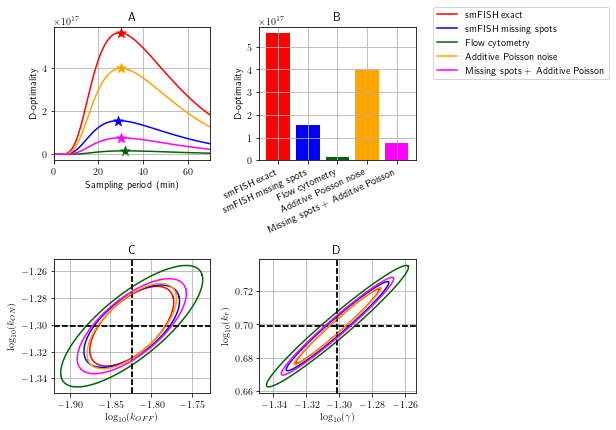

In [43]:
with np.load("results/opt_sampling_periods.npz", allow_pickle=True) as _:
    opt_rates = _["opt_rates"][()]
    fim_multi_cells_times = _["fim_multi_cells_times"][()]
    det_fim_multi_cells_times = _["det_fim_multi_cells_times"][()]

DT_MAX = 70
fig, axs = plt.subplots(2,2)
fig.set_size_inches(6, 6)
fig.set_tight_layout(True)
for im, meas in enumerate(measurement_methods):
    idx_opt = opt_rates[meas]
    fims = fim_multi_cells_times[meas]
    dets = det_fim_multi_cells_times[meas]
    dt_array = np.linspace(0, len(dets)-1, len(dets))
    
    axs[0,0].plot(dt_array, dets, label=labels[meas], color=colors[meas])
    axs[0,0].scatter(dt_array[idx_opt],
                   dets[idx_opt],
               100,
               color=colors[meas],
                   marker='*')

    axs[0,1].bar(im, dets[idx_opt], color=colors[meas])

    plot_conf_ellipse(fims[idx_opt],
                      3,
                      axs[1,0],
                      [1,0],
                      np.log10(theta),
                      colors[meas], '')
    plot_conf_ellipse(fims[idx_opt],
                      3,
                      axs[1,1],
                      [3,2],
                      np.log10(theta), colors[meas], '')

h, l = axs[0,0].get_legend_handles_labels()
fig.legend(h, l, bbox_to_anchor=(1, 0, 1, 1), loc='upper left', ncol=1)
axs[0, 0].set_xlim([0, DT_MAX])
axs[0, 0].set_xlabel('Sampling period (min)')
axs[0, 0].set_ylabel('D-optimality')

axs[0, 1].set_ylabel('D-optimality')
axs[0, 1].set_xticks(range(len(measurement_methods)))
axs[0, 1].set_xticklabels([labels[m] for m in measurement_methods], rotation=25, ha='right')

axs[1,0].set_ylabel('$\log_{10}({k_{ON}})$')
axs[1,0].set_xlabel('$\log_{10}({k_{OFF}})$')
axs[1,1].set_ylabel('$\log_{10}({k_{r}})$')
axs[1,1].set_xlabel('$\log_{10}({\gamma})$')

for ax in list(axs.flatten()):
    ax.grid(True)
label_axes(axs)
fig.savefig('figs/bursting_fim_dopt.pdf', bbox_inches='tight')

In [51]:
import pandas as pd

lst = []
for design in measurement_methods:
    dt_opt = opt_rates[design]
    d_opt = det_fim_multi_cells_times[design][dt_opt]
    lst.append(
        [labels[design],
        dt_opt,
        d_opt]
    )
df = pd.DataFrame(lst, columns=['Design', 'Optimal sampling period (minute)', 'D-optimal information'])
df.to_csv("tables/bursting_designs.csv", index=False, float_format="%.2e")

## Optimal combination of Poisson-additive and random spot-missing measurements

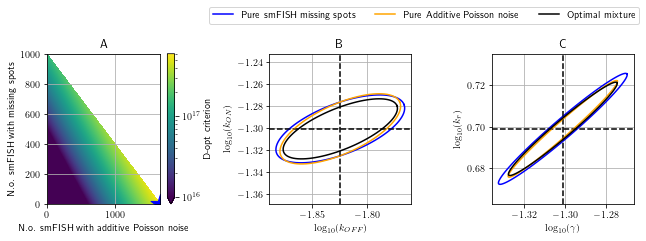

In [44]:
import matplotlib.colors as Colors

with np.load("results/opt_mixture.npz", allow_pickle=True) as _:
         opt_mixture=_["opt_mixture"]
         obj_values=_["obj_values"]
         fim_mix_opt=_["fim_mix_opt"]

fig, axs = plt.subplots(1,3)
fig.set_size_inches(9, 3)
fig.set_tight_layout(True)

mixture_plot = axs[0].pcolorfast(obj_values, norm=Colors.LogNorm(vmin=1.0E16, vmax=6E17))
fig.colorbar(mixture_plot, ax=axs[0], orientation='vertical', extend='min',
             label=r"D-opt criterion")
axs[0].scatter(opt_mixture[1], opt_mixture[0], 400, marker='*', color="blue")
axs[0].set_xlabel("N.o. smFISH with additive Poisson noise")
axs[0].set_ylabel("N.o. smFISH with missing spots")

for meas in ['binomial', 'poisson']:
    idx_opt = opt_rates[meas]
    fims = fim_multi_cells_times[meas]
    dets = det_fim_multi_cells_times[meas]

    plot_conf_ellipse(fims[idx_opt],
                      3,
                      axs[1],
                      [1,0],
                      np.log10(theta),
                      colors[meas], f'Pure {labels[meas]}')
    plot_conf_ellipse(fims[idx_opt],
                      3,
                      axs[2],
                      [3,2],
                      np.log10(theta), colors[meas], f'Pure {meas}')
plot_conf_ellipse(fim_mix_opt,
                      3,
                      axs[1],
                      [1,0],
                      np.log10(theta),
                      'k', 'Optimal mixture')
plot_conf_ellipse(fim_mix_opt,
                  3,
                  axs[2],
                  [3,2],
                  np.log10(theta), 'k', 'Optimal mixture')

h, l = axs[1].get_legend_handles_labels()
fig.legend(h, l, bbox_to_anchor=(0, 1, 1, 1), loc='lower right', ncol=5)

for j in range(1, 3):
    axs[j].set_aspect('equal', 'datalim')
    axs[j].grid()
axs[1].set_ylabel('$\log_{10}({k_{ON}})$')
axs[1].set_xlabel('$\log_{10}({k_{OFF}})$')
axs[2].set_ylabel('$\log_{10}({k_{r}})$')
axs[2].set_xlabel('$\log_{10}({\gamma})$')
axs[0].grid()
label_axes(axs)
fig.savefig("figs/bursting_mixture_dopt.png", dpi=300, bbox_inches="tight")

## Heatmaps for the probability kernels

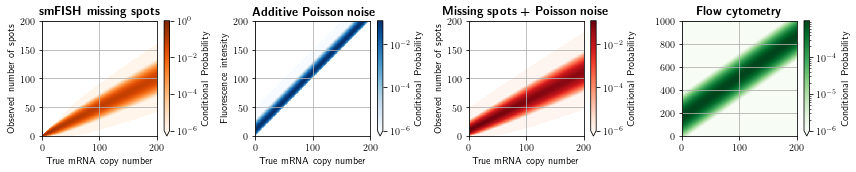

In [49]:
pdos = {}
for s in ["binomial", "poisson", "binomial_poisson", "flowcyt"]:
    with np.load(f'results/distortion_matrix_{s}.npz') as data:
        pdos[s] = data['C']
pdo_colors = ["Oranges", "Blues", "Reds", "Greens"]

fig, axs = plt.subplots(1, 4)
fig.set_size_inches(12, 2.5)
fig.set_tight_layout(True)

for i,s in enumerate(pdos.keys()):
    C = pdos[s][:, :200]
    p = axs[i].pcolorfast(C, norm=Colors.LogNorm(vmin=1.0E-6),
                         cmap=plt.cm.get_cmap(pdo_colors[i]))
    fig.colorbar(p, ax=axs[i], orientation='vertical', extend='min', label=r"Conditional Probability")

for j in range(0,3):
    axs[j].set_xlabel('True mRNA copy number')
    axs[j].set_ylabel('Observed number of spots')
    axs[j].set_ylim([0, 200])
axs[1].set_ylabel('Fluorescence intensity')

models = ['smFISH missing spots',
          "Additive Poisson noise",
          'Missing spots + Poisson noise',
          'Flow cytometry']
for j in range(len(models)):
    axs[j].set_title(rf'\textbf{{{models[j]}}}')
    axs[j].grid()
fig.savefig('figs/bursting_kernel_maps.png', bbox_inches='tight', dpi=200)

## Effects of distortion on the mRNA distribution

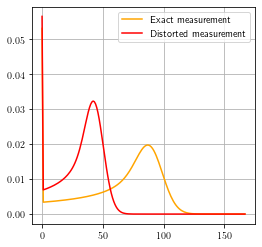

In [46]:
t = 60

p = rna_distributions[t]
p_distorted = pdos["binomial"][:len(p),:len(p)]@p

fig, ax = plt.subplots(1,1)
fig.set_size_inches(4,4)
ax.plot(p, label="Exact measurement", color="orange")
ax.plot(p_distorted, label="Distorted measurement", color="red")
ax.legend()
ax.grid()
fig.savefig("figs/bursting_distorted_dists.pdf", bbox_inches="tight")

